In [29]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.distributions import Gumbel

In [30]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

M = 4
SNR_dB = 15

constellationDim = 2
constellationOrder = M
temperature = torch.tensor(1, dtype=torch.float32)

nBatches = 16
batchsize = 4*M
learning_rate = 0.001
displayStep = 1
iterations = 500

In [31]:
one = torch.tensor(1, dtype=torch.float32)
zero = torch.tensor(0, dtype=torch.complex64)
twoZeroCpx = torch.tensor(2, dtype=torch.complex64)

def Qammod(M):
    r = np.arange(np.array(np.sqrt(M)))
    r = 2*(r - np.mean(r))
    r = np.meshgrid(r,r)
    constellation = np.expand_dims(np.reshape(r[0]+1j*r[1],[-1]),axis = 0)
    norm = np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation/norm

#make sure that expected energy of the constellation equals unity: sigma(p. x^2) = 1
def p_norm(p, x, fun=lambda x: torch.square(torch.abs(x))):
    return torch.sum(p*fun(x))


def r2c(x):
    return x.to(torch.complex64)

def c2r(x):
    return x.to(torch.float32)

def complex2real(x, axis=-1):
    real_part = torch.real(x)
    imag_part = torch.imag(x)
    return torch.stack((real_part, imag_part), axis=axis)

def real2complex(x, axis=-1):
    real_part = torch.index_select(x, axis, torch.tensor(0, device=x.device))
    imag_part = torch.index_select(x, axis, torch.tensor(1, device=x.device))
    return torch.complex(real_part, imag_part)

#custom gradient for gumbel sampling
class StraightThroughEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, s_bar, M):
        s = F.one_hot(torch.argmax(s_bar, dim=-1), num_classes=M).float()
        return s

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None

def straight_through_estimator(s_bar, M):
    return StraightThroughEstimator.apply(s_bar, M)


def dB2lin(dB, dBtype):
    if dBtype in ['db', 'dB']:
        fact = 0
    elif dBtype in ['dbm', 'dBm']:
        fact = -30
    elif dBtype in ['dbu', 'dBu']:
        fact = -60
    else:
        raise ValueError('dBtype can only be dB, dBm or dBu.')

    fact = torch.tensor(fact)
    ten = torch.tensor(10)
    return ten**((dB + fact) / ten)


def OFDM_Channel(signal, input_SNR):
    signal_ifft = torch.fft.ifft(signal)
    papr = find_PAPR(signal_ifft)


    signal_power = torch.mean(torch.abs(signal_ifft)**2)
    noise_power = 10**(-input_SNR / 10)*signal_power
    sigma = torch.tensor(torch.sqrt(noise_power))
    noise = torch.normal(mean=zero, std=sigma, size=signal_ifft.size(), device=signal_ifft.device) + 1j*torch.normal(mean=zero, std=sigma, size=signal_ifft.size(), device=signal_ifft.device)

    clipped_signal = clip_with_15_percent(signal_ifft)
    papr_clipped = find_PAPR(clipped_signal)

    receiver_signal = signal_ifft + noise
    signal_fft = torch.fft.fft(receiver_signal)
    return signal_fft, papr, papr_clipped


def clip_with_15_percent(signal):
    max_amplitude = torch.max(torch.abs(signal))
    threshold = 0.85 * max_amplitude
    clipped_signal = torch.clamp(torch.real(signal), -threshold, threshold) + 1j * torch.clamp(torch.imag(signal), -threshold, threshold)
    return clipped_signal

def find_PAPR(after_ifft):
    papr = torch.max(torch.square(torch.abs(after_ifft)))/torch.mean(torch.square(torch.abs(after_ifft)))
    return 10*torch.log10(papr)

def Find_SER(x, y):
    y = y.flatten()
    x = x.flatten()
    #demap
    distances = torch.abs(y.unsqueeze(1) - x.unsqueeze(0)) ** 2
    closest_indices = torch.argmin(distances, dim=1)  # Shape [N]
    closest_points = x[closest_indices]  # Map indices to points
    #calculate SER
    x = x.detach().cpu().numpy()
    closest_points = closest_points.detach().cpu().numpy()
    temp = np.mean(closest_points != x)
    SER = torch.tensor(temp, dtype=torch.float32)
    return SER

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, M),
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(M, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, constellationDim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, M),
        )
    def forward(self, input_SNR):
        #SAMPLING
        enc_inp = torch.ones((1,1), dtype = torch.float32) #tam thoi truyen 1 symbol = 1 + 0j
        s_logits = self.encoder1(enc_inp)
        g_dist = Gumbel(loc=0.0, scale=1.0)
        g = g_dist.sample(sample_shape=(batchsize, M))
        s_bar = F.softmax((g + s_logits)/temperature)
        #STRAIGHT_THROUGH_ESTIMATOR
        self.s = straight_through_estimator(s_bar, M)
        #GEO_SHAPING
        
        xSeed = torch.eye(constellationOrder, dtype=self.s.dtype)
        constellation_vec = self.encoder2(xSeed)
        real_part = constellation_vec[:, 0] #return value of column 0
        imag_part = constellation_vec[:, 1] #return value of column 1
        constellation_cpx = torch.complex(real_part, imag_part)
        constellation = torch.unsqueeze(constellation_cpx, 0)
        enc_vec = self.encoder2(self.s)
        r_vec = enc_vec[:, 0]
        i_vec = enc_vec[:, 1]
        enc = torch.complex(r_vec, i_vec)
        enc = torch.unsqueeze(enc, -1)
        #NORMALIZATION & MODULATION
        self.p_s = F.softmax(s_logits)
        norm_factor = torch.rsqrt(p_norm(self.p_s, constellation))
        self.norm_constellation = r2c(norm_factor) * constellation
        self.x = r2c(norm_factor)*enc
        self.should_always_be_one = p_norm(self.p_s, self.norm_constellation)
        self.y, self.papr, self.papr_clip = OFDM_Channel(self.x, input_SNR)
        self.SER = Find_SER(self.x, self.y)
        y_vec = complex2real(torch.squeeze(self.y))
        dec = self.decoder(y_vec)

        return dec 



In [33]:
def gaussianMI(x, y, constellation, M, dtype=torch.float64):
    if len(constellation.shape) == 1:
        constellation = constellation.unsqueeze(0)
    if len(y.shape) == 1:
        y = y.unsqueeze(0)
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    if y.shape[0] != 1:
        y = y.T
    if x.shape[0] != 1:
        x = x.T
    if constellation.shape[0] == 1:
        constellation = constellation.T

    N = torch.tensor(x.shape[1], dtype=dtype)

    PI = torch.tensor(np.pi, dtype=dtype)
    REALMIN = torch.tensor(np.finfo(float).tiny, dtype=dtype)

    xint = torch.argmin(torch.square(torch.abs(x - constellation)), dim=0)
    x_count = torch.bincount(xint, minlength=M)
    P_X = x_count.to(dtype) / N

    N0 = torch.mean(torch.square(torch.abs(x - y)))

    qYonX = 1 / (PI * N0) * torch.exp((-torch.square(torch.real(y) - torch.real(x)) - torch.square(torch.imag(y) - torch.imag(x))) / N0)

    qY = []
    for ii in range(M):
        temp = P_X[ii] * (1 / (PI * N0) * torch.exp(
            (-torch.square(torch.real(y) - torch.real(constellation[ii, 0])) - torch.square(torch.imag(y) - torch.imag(constellation[ii, 0]))) / N0))
        qY.append(temp)
    qY = torch.sum(torch.stack(qY, dim=0), dim=0)

    MI = 1 / N * torch.sum(torch.log2(torch.maximum(qYonX, REALMIN) / torch.maximum(qY, REALMIN)))

    return MI  


In [34]:
autoencoder = Autoencoder()
def initialize_model(autoencoder):
    for layer in autoencoder.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

initialize_model(autoencoder)
input_SNR = torch.tensor(SNR_dB, dtype=torch.float32, requires_grad=False)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(reduction='none')
np_x = []
np_y = []
papr_values = []
papr_clipping = []

for epoch in range(1, iterations + 1):
    for batch in range(nBatches):
        decoder_out = autoencoder(input_SNR)
        optimizer.zero_grad()
        np_x.append(autoencoder.x.detach().cpu().numpy())
        np_y.append(autoencoder.y.detach().cpu().numpy())
        papr_clipping.append(autoencoder.papr_clip.item())
        papr_values.append(autoencoder.papr.item())
        loss = criterion(decoder_out, autoencoder.s.argmax(dim=-1))
        entropy_S = -p_norm(autoencoder.p_s, autoencoder.p_s, lambda p_s: torch.log2(p_s))
        loss_hat = loss - entropy_S
        gaussian_MI = gaussianMI(autoencoder.x, autoencoder.y, autoencoder.norm_constellation, M, dtype =  torch.float32)
        loss_hat.mean().backward()
        optimizer.step()
        
    if epoch % displayStep == 0:
        print('epoch: {} - lossHat: {:.3f} - gaussianMI: {:.3f} - SER: {} - PAPR: {}'.
            format(epoch, loss_hat.mean().item(), gaussian_MI.item(), autoencoder.SER, autoencoder.papr))

C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_8112\4004542312.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_bar = F.softmax((g + s_logits)/temperature)
C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_8112\4004542312.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.p_s = F.softmax(s_logits)
C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_8112\874307062.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(torch.sqrt(noise_power))


epoch: 1 - lossHat: -1.198 - gaussianMI: 1.901 - SER: 0.0 - PAPR: 2.905704975128174
epoch: 2 - lossHat: -1.846 - gaussianMI: 1.936 - SER: 0.0 - PAPR: 1.7748222351074219
epoch: 3 - lossHat: -1.985 - gaussianMI: 1.977 - SER: 0.0 - PAPR: 1.0563030242919922
epoch: 4 - lossHat: -1.977 - gaussianMI: 1.883 - SER: 0.0 - PAPR: 1.406436562538147
epoch: 5 - lossHat: -1.995 - gaussianMI: 1.883 - SER: 0.0 - PAPR: 1.6709755659103394
epoch: 6 - lossHat: -1.998 - gaussianMI: 1.977 - SER: 0.0 - PAPR: 1.7383043766021729
epoch: 7 - lossHat: -1.995 - gaussianMI: 1.850 - SER: 0.0 - PAPR: 1.15486741065979
epoch: 8 - lossHat: -1.999 - gaussianMI: 1.803 - SER: 0.0 - PAPR: 2.1913464069366455
epoch: 9 - lossHat: -1.970 - gaussianMI: 1.673 - SER: 0.0 - PAPR: 2.4118170738220215
epoch: 10 - lossHat: -1.998 - gaussianMI: 1.954 - SER: 0.0 - PAPR: 1.1221669912338257
epoch: 11 - lossHat: -1.992 - gaussianMI: 1.952 - SER: 0.0 - PAPR: 0.7134076356887817
epoch: 12 - lossHat: -1.988 - gaussianMI: 1.579 - SER: 0.0 - PAPR: 

(-1.8428452149700147,
 1.5734119227636905,
 -1.3471862713470872,
 2.069070866386618)

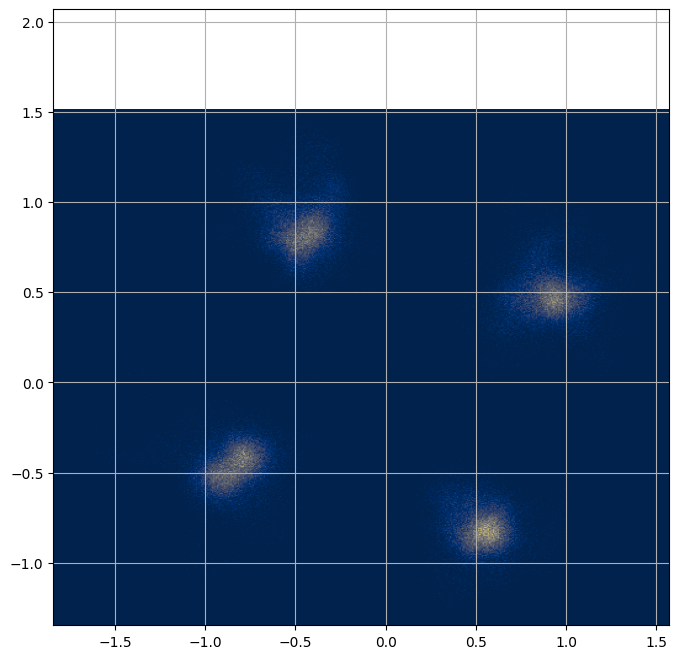

In [35]:
all_y = np.reshape(np.stack(np_y),-1)
all_x = np.reshape(np.stack(np_x),-1)

noise = np.random.normal(0,1,size=all_x.shape)+1j*np.random.normal(0,1,size=all_x.shape)
all_x = all_x + 0.05*noise
heatmap, xedges, yedges = np.histogram2d(np.real(all_x), np.imag(all_x), bins=500)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,8))
plt.imshow(heatmap.T,cmap= 'cividis', extent=extent, origin='lower')
plt.grid(True)
plt.axis('square')